In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ——— GazelleOptimizer with Lévy flight & Brownian motion ——————————
def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    if np.random.rand() < prob_brownian:
        return np.random.normal(0, 0.1, size)
    else:
        sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
                     (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)
        u = np.random.normal(0, sigma_levy, size)
        v = np.random.normal(0, 1, size)
        return u/(np.abs(v)**(1/lam))

class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1,
                 num_gazelles=10, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum,
                        exploration_factor=exploration_factor,
                        num_gazelles=num_gazelles)
        super().__init__(params, defaults)
        self.prob_brownian = prob_brownian
        self.gazelles = None

    def initialize_population(self, shape, device, dtype):
        lb, ub = -1., 1.
        self.gazelles = torch.empty(
            (self.defaults['num_gazelles'], *shape),
            device=device, dtype=dtype
        ).uniform_(lb, ub)

    def step(self, closure=None):
        loss = closure() if closure else None
        for group in self.param_groups:
            lr = group['lr']
            m = group['momentum']
            ef = group['exploration_factor']
            ng = group['num_gazelles']

            for p in group['params']:
                if p.grad is None: continue
                d = p.grad.data
                shape = d.shape

                if self.gazelles is None or self.gazelles.shape[1:] != shape:
                    self.initialize_population(shape, p.device, p.dtype)

                vec = torch.tensor(
                    levy_brownian_step(self.prob_brownian, size=d.numel()),
                    device=p.device, dtype=p.dtype
                ).view_as(d).detach()

                for i in range(ng):
                    self.gazelles[i].add_(ef * vec).clamp_(-1., 1.)

                buf = self.state[p].get('momentum_buffer', None)
                if buf is None:
                    buf = d.clone()
                    self.state[p]['momentum_buffer'] = buf
                else:
                    buf.mul_(m).add_(d)
                elite = self.gazelles.mean(0)
                p.data.add_( -(buf + ef*elite) * lr )
        return loss

In [9]:
# ——— Data Preparation —————————————————————————————————————————————
dataset_path = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_train"
batch_size, num_classes = 32, 7
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(name, num_classes):
    if name == 'resnet18':
        model = models.squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes

    elif name == 'squeezenet1_1':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model name: {name}")

    return model.to(device)

In [13]:
num_classes = 7  # adjust for your classification problem
model_names = ['squeezenet1_1', 'resnet18', 'vgg16', 'mobilenet_v2']

# Create models with distinct names
models_dict = {}
for name in model_names:
    model = create_model(name, num_classes)
    models_dict[name] = model
# ——— Training & Evaluation Functions —————————————————————————————————
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss = criterion(out, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = out.argmax(1)
            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()

    metrics = {
        'loss': total_loss/len(loader.dataset),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'mcc': matthews_corrcoef(all_labels, all_preds)
    }
    return metrics

C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up

In [15]:
# ——— Training Loop Across Models ——————————————————————————————————
num_epochs, lr = 10, 0.001
histories, final_metrics = {}, {}

for name, model in models_dict.items():
    print(f"\n=== Training {name} ===")
    optimizer = GazelleOptimizer(model.parameters(), lr=lr, momentum=0.9,
                                 exploration_factor=0.1, prob_brownian=0.3)
    criterion = nn.CrossEntropyLoss()
    h = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for ep in range(num_epochs):
        tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
        vm = evaluate(model, val_loader, criterion)
        h['train_loss'].append(tl)
        h['val_loss'].append(vm['loss'])
        h['train_acc'].append(ta)
        h['val_acc'].append(vm['accuracy'])
        print(f"Ep {ep+1}/{num_epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}, val_acc={vm['accuracy']:.4f}")

    histories[name] = h
    final_metrics[name] = evaluate(model, val_loader, criterion)


=== Training squeezenet1_1 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.2445, train_acc=0.5323, val_acc=0.6396


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.6415, train_acc=0.7729, val_acc=0.7613


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.4081, train_acc=0.8643, val_acc=0.7763


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.2565, train_acc=0.9267, val_acc=0.8634


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.1400, train_acc=0.9707, val_acc=0.8814


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.1052, train_acc=0.9805, val_acc=0.8769


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.0906, train_acc=0.9861, val_acc=0.9114


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.0563, train_acc=0.9940, val_acc=0.9099


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.0383, train_acc=0.9959, val_acc=0.9354


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0315, train_acc=0.9974, val_acc=0.9264

=== Training resnet18 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.3874, train_acc=0.4594, val_acc=0.4399


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.9733, train_acc=0.6305, val_acc=0.6261


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.7773, train_acc=0.6996, val_acc=0.6321


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.6889, train_acc=0.7259, val_acc=0.7027


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.5812, train_acc=0.7771, val_acc=0.7117


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.4734, train_acc=0.8222, val_acc=0.6697


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.4667, train_acc=0.8241, val_acc=0.7823


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.3795, train_acc=0.8586, val_acc=0.7898


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.3523, train_acc=0.8737, val_acc=0.6907


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.3432, train_acc=0.8733, val_acc=0.8333

=== Training vgg16 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.1859, train_acc=0.5109, val_acc=0.5916


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.7208, train_acc=0.7184, val_acc=0.7868


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.5773, train_acc=0.7801, val_acc=0.7523


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.3628, train_acc=0.8722, val_acc=0.8408


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.2014, train_acc=0.9259, val_acc=0.7793


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.2025, train_acc=0.9267, val_acc=0.8649


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.1192, train_acc=0.9586, val_acc=0.8934


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.1313, train_acc=0.9530, val_acc=0.8919


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.1165, train_acc=0.9602, val_acc=0.8318


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0905, train_acc=0.9695, val_acc=0.9054

=== Training mobilenet_v2 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.1900, train_acc=0.5451, val_acc=0.6772


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.6530, train_acc=0.7571, val_acc=0.7643


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.4188, train_acc=0.8541, val_acc=0.7973


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.2843, train_acc=0.9098, val_acc=0.8619


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.1784, train_acc=0.9466, val_acc=0.8904


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.1506, train_acc=0.9549, val_acc=0.8964


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.0923, train_acc=0.9759, val_acc=0.8994


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.0695, train_acc=0.9827, val_acc=0.9054


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.0513, train_acc=0.9898, val_acc=0.9054


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0972, train_acc=0.9703, val_acc=0.8814


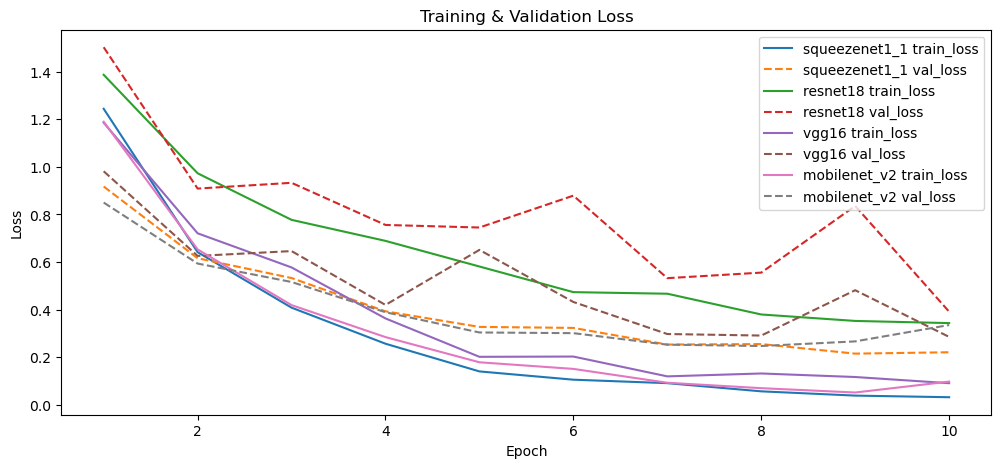

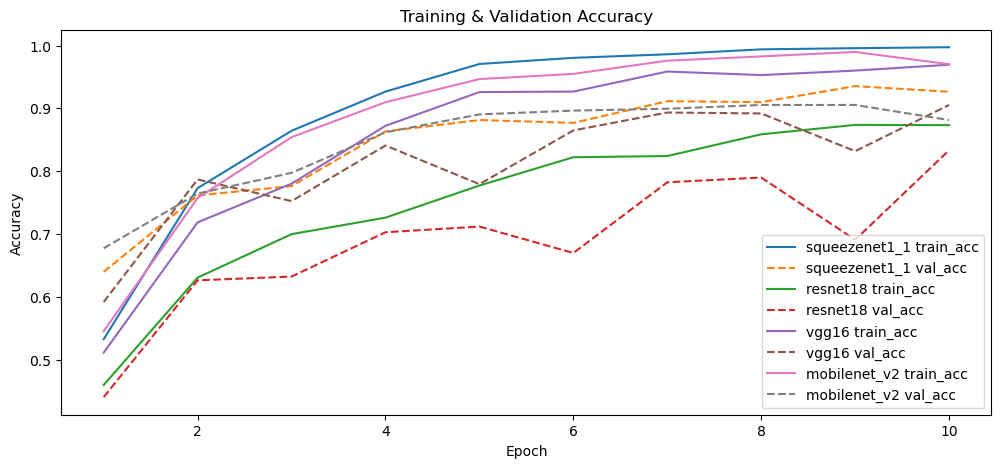

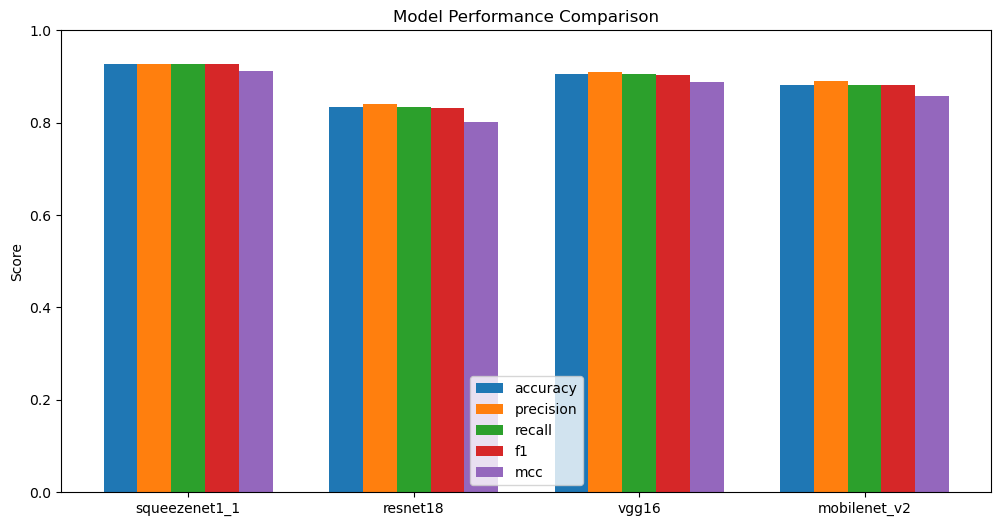

In [16]:
# ——— Visualization —————————————————————————————————————————————
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy'); plt.legend(); plt.show()

# Bar chart of final metrics
metrics_list = ['accuracy','precision','recall','f1','mcc']
n_models = len(model_names)
bar_width, indices = 0.15, np.arange(n_models)
plt.figure(figsize=(12,6))
for i, metric in enumerate(metrics_list):
    vals = [final_metrics[m][metric] for m in model_names]
    plt.bar(indices + i*bar_width, vals, width=bar_width, label=metric)
plt.xticks(indices + bar_width*2, model_names)
plt.ylim(0,1)
plt.ylabel('Score'); plt.title('Model Performance Comparison'); plt.legend(); plt.show()



=== Final Validation Accuracy and Loss for All Models ===
squeezenet1_1: Accuracy = 0.9264, Loss = 0.2206
resnet18: Accuracy = 0.8333, Loss = 0.3912
vgg16: Accuracy = 0.9054, Loss = 0.2851
mobilenet_v2: Accuracy = 0.8814, Loss = 0.3351


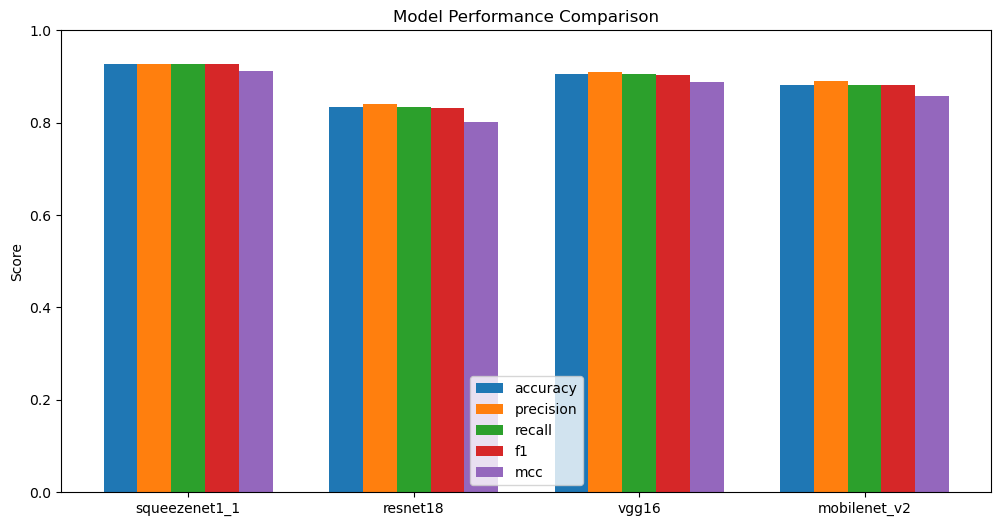

In [19]:
# ——— Print Final Accuracy and Loss for All Models ——————————————————
print("\n=== Final Validation Accuracy and Loss for All Models ===")
for name in model_names:
    acc = final_metrics[name]['accuracy']
    loss = final_metrics[name]['loss']
    print(f"{name}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# ——— Bar Chart of Final Metrics ————————————————————————————————
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
n_models = len(model_names)
bar_width = 0.15
indices = np.arange(n_models)

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_list):
    vals = [final_metrics[m][metric] for m in model_names]
    plt.bar(indices + i * bar_width, vals, width=bar_width, label=metric)

plt.xticks(indices + bar_width * 2, model_names)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

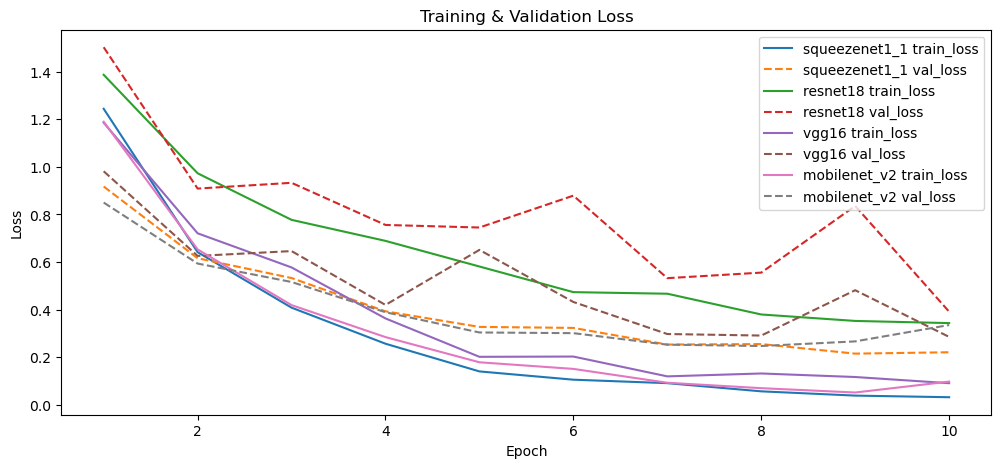

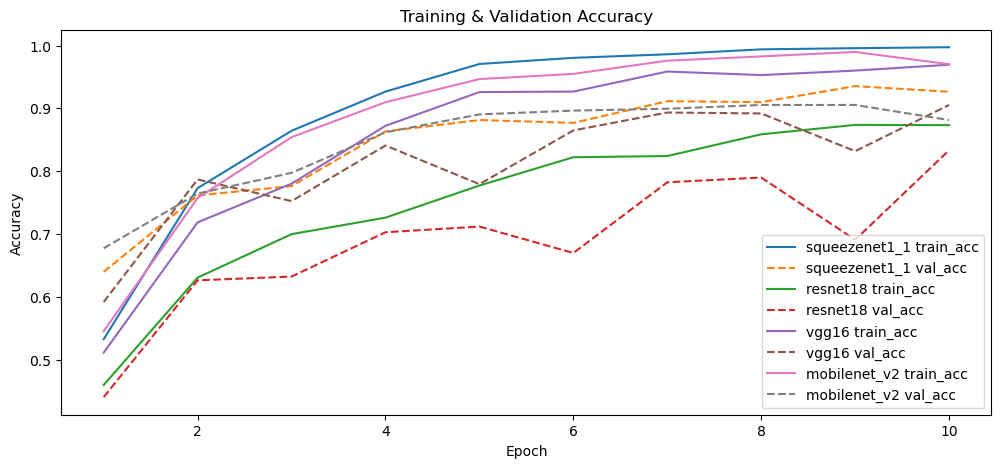

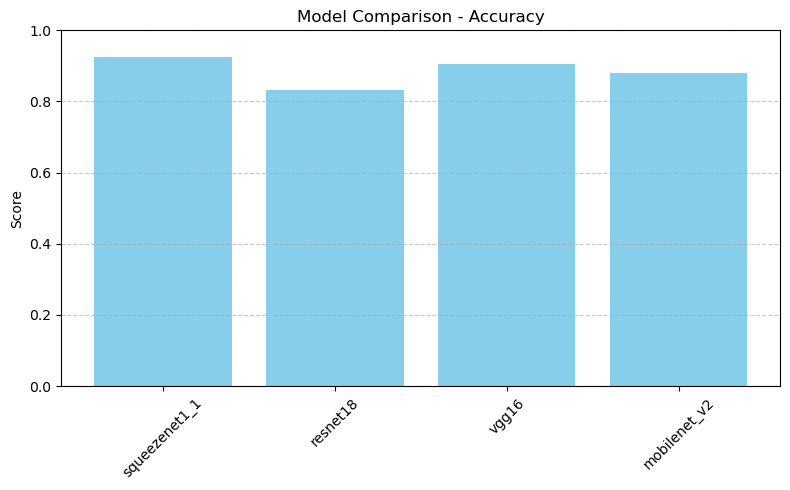

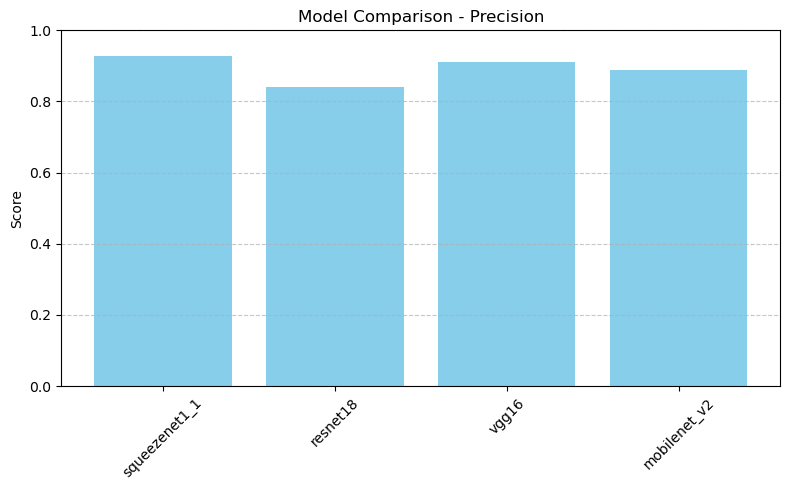

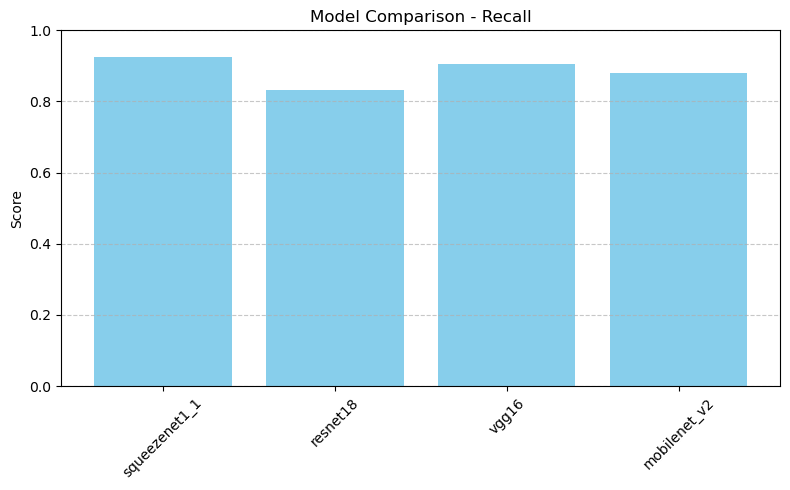

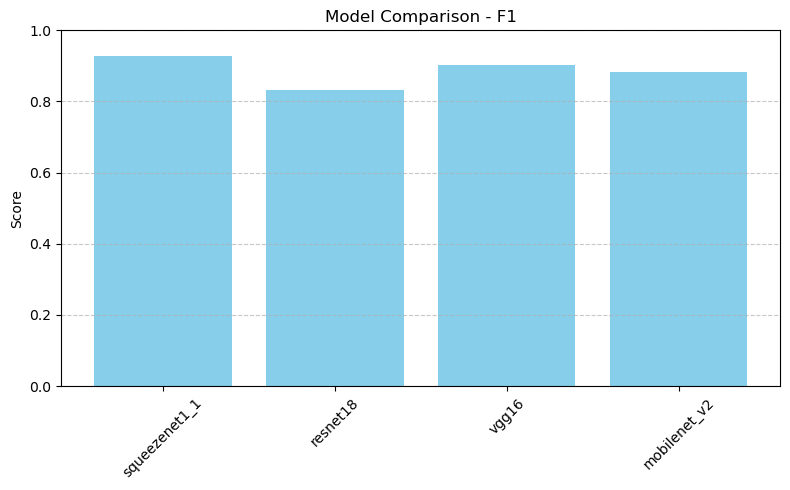

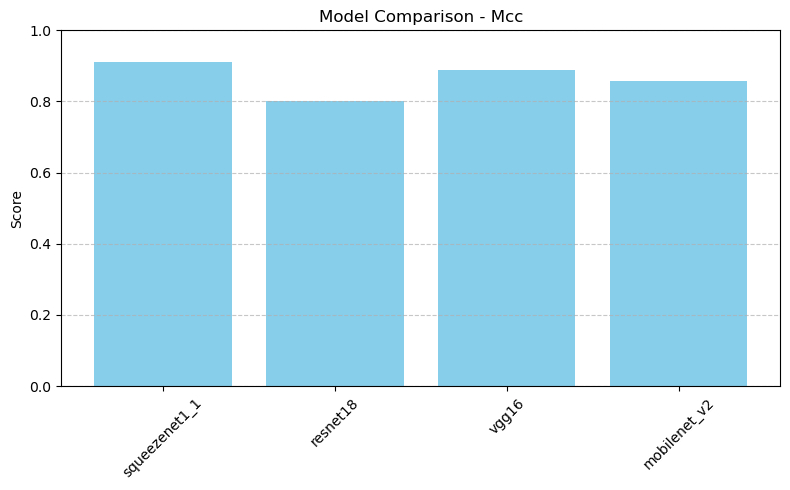

In [21]:
# ——— Visualization —————————————————————————————————————————————
epochs = range(1, num_epochs + 1)

# Line plot for Loss
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Line plot for Accuracy
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# Separate bar charts: one metric per chart
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
model_names = list(final_metrics.keys())

for metric in metrics_list:
    plt.figure(figsize=(8, 5))
    values = [final_metrics[model][metric] for model in model_names]
    plt.bar(model_names, values, color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title(f'Model Comparison - {metric.capitalize()}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


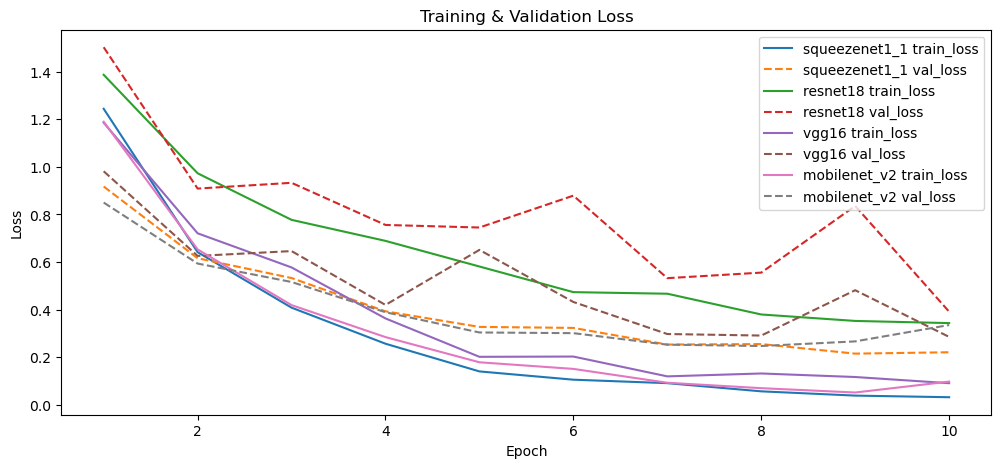

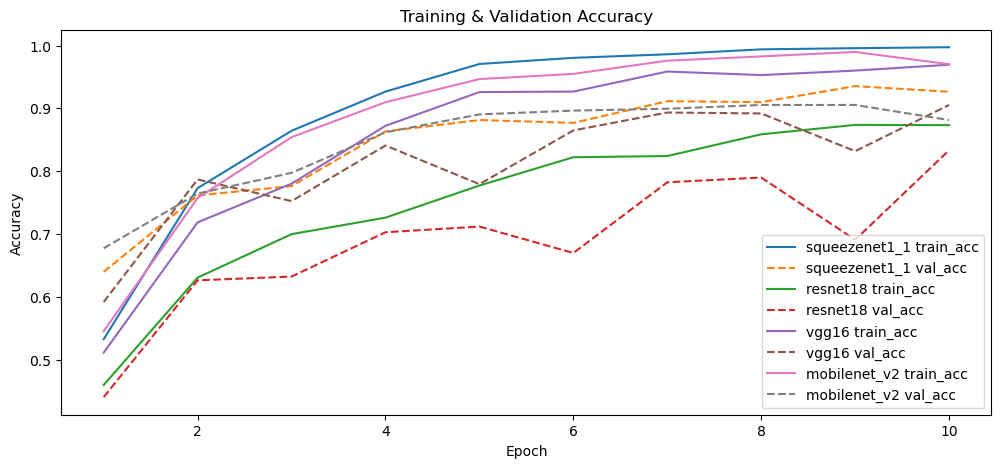

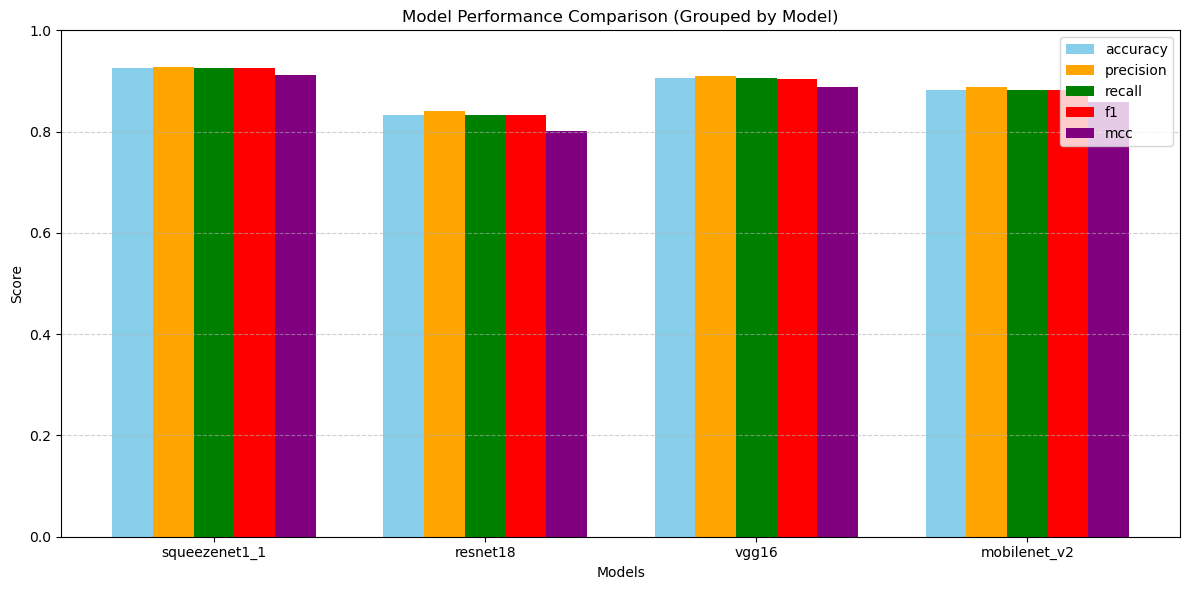

In [23]:
# ——— Visualization —————————————————————————————————————————————
epochs = range(1, num_epochs + 1)

# Line plot for Loss
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Line plot for Accuracy
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# ——— Grouped Bar Chart for Final Metrics ——————————————————————
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
model_names = list(final_metrics.keys())
n_models = len(model_names)
n_metrics = len(metrics_list)

bar_width = 0.15
indices = np.arange(n_models)

colors = ['skyblue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_list):
    values = [final_metrics[model][metric] for model in model_names]
    bar_positions = indices + i * bar_width
    plt.bar(bar_positions, values, width=bar_width, label=metric, color=colors[i % len(colors)])

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Grouped by Model)')
plt.xticks(indices + bar_width * (n_metrics - 1) / 2, model_names)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


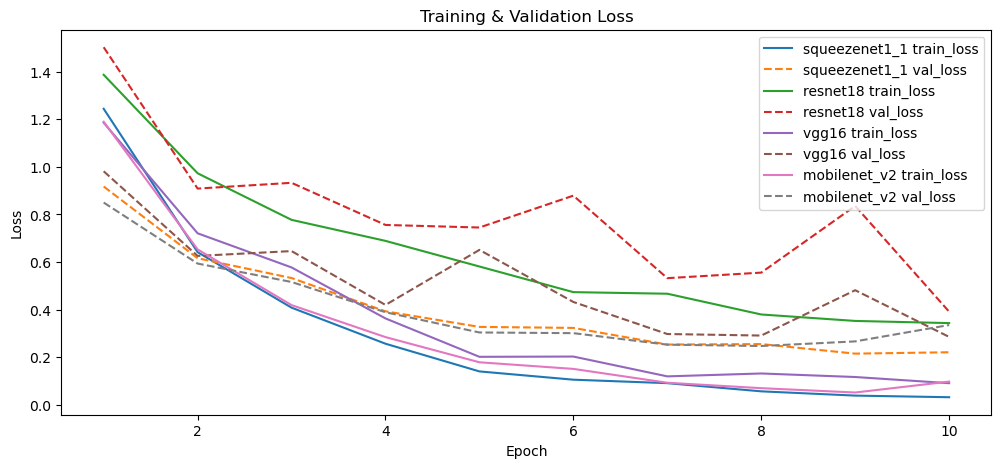

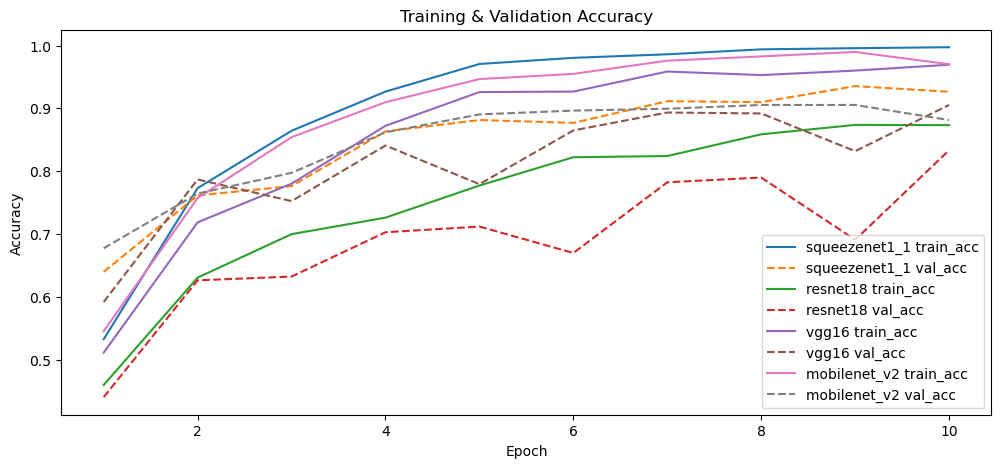

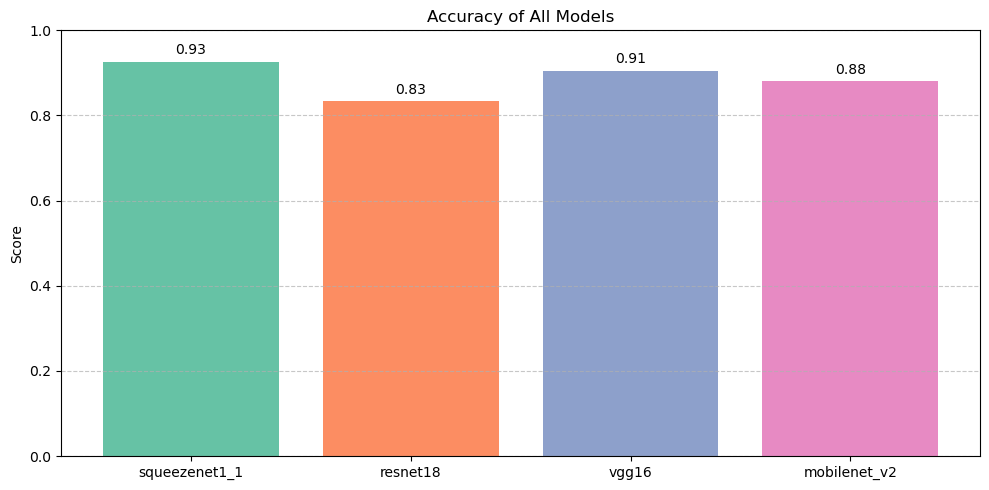

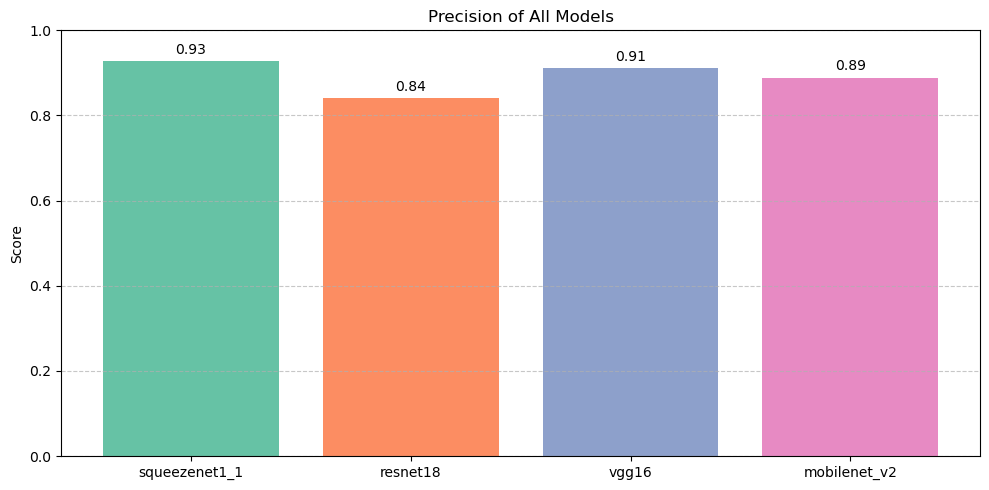

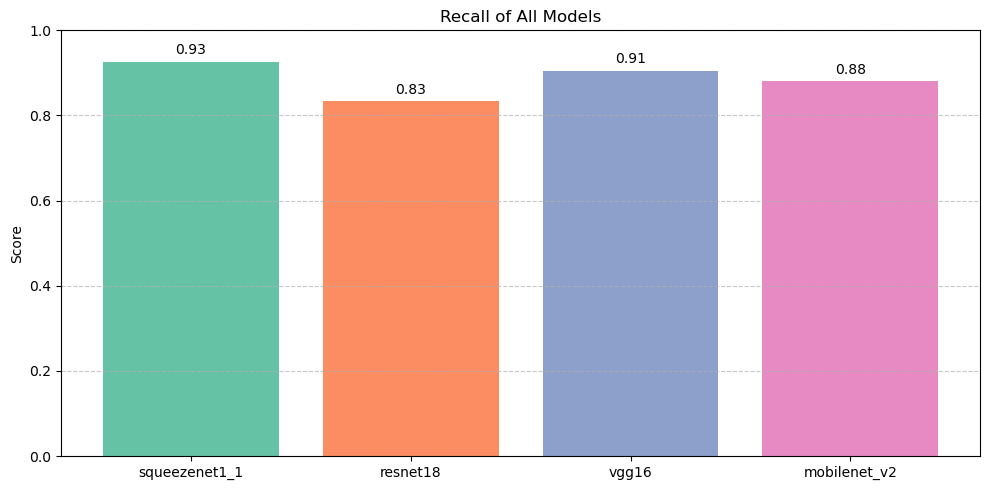

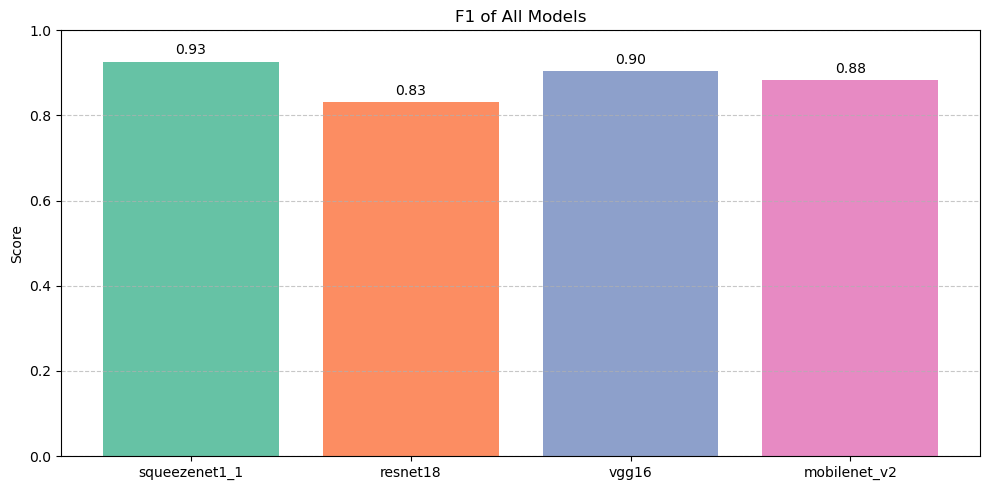

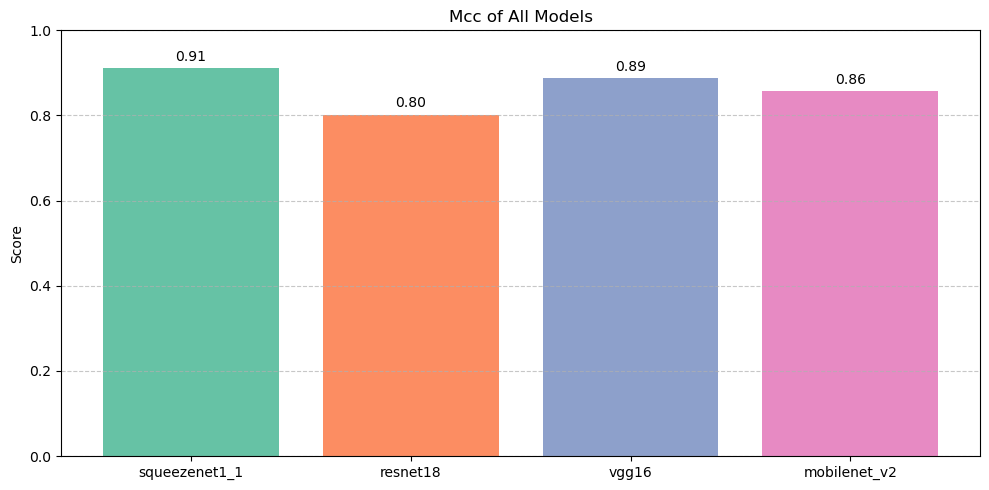

In [25]:
# ——— Line Plot for Loss ——————————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# ——— Line Plot for Accuracy ————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# ——— One Bar Chart per Metric —————————————————————————
import seaborn as sns

metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
model_names = list(final_metrics.keys())
colors = sns.color_palette("Set2", len(model_names))  # distinct colors

for metric in metrics_list:
    values = [final_metrics[model][metric] for model in model_names]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(model_names, values, color=colors)
    
    # Annotate bars with value
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2.0, value + 0.01, f"{value:.2f}", 
                 ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title(f'{metric.capitalize()} of All Models')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


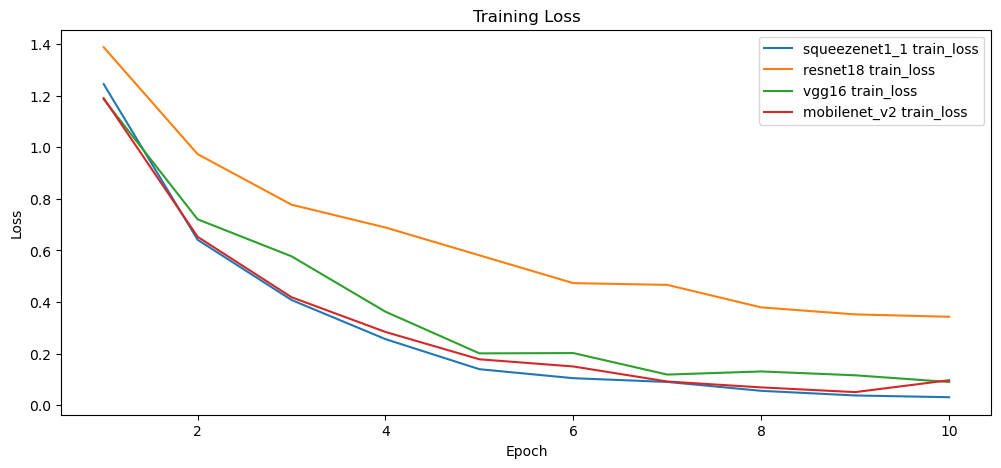

In [70]:
# ——— Line Plot for Loss ——————————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


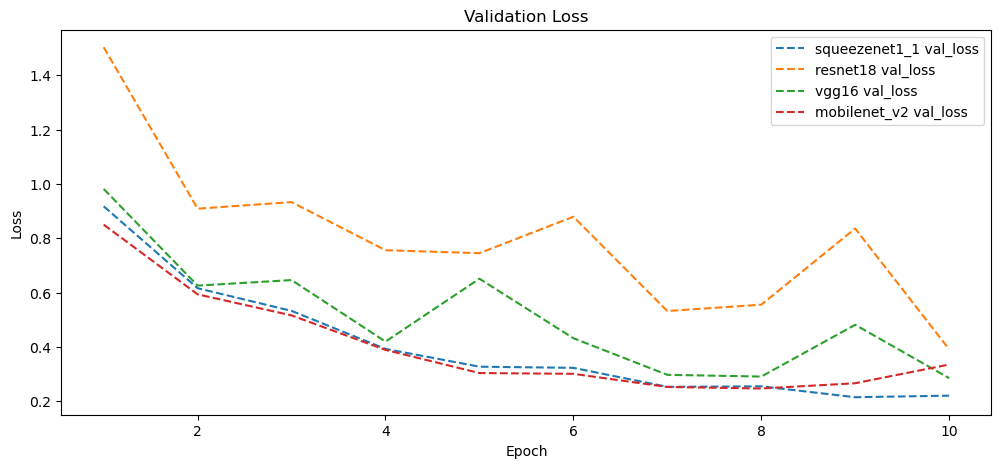

In [72]:
# ——— Line Plot for Loss ——————————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
 
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()



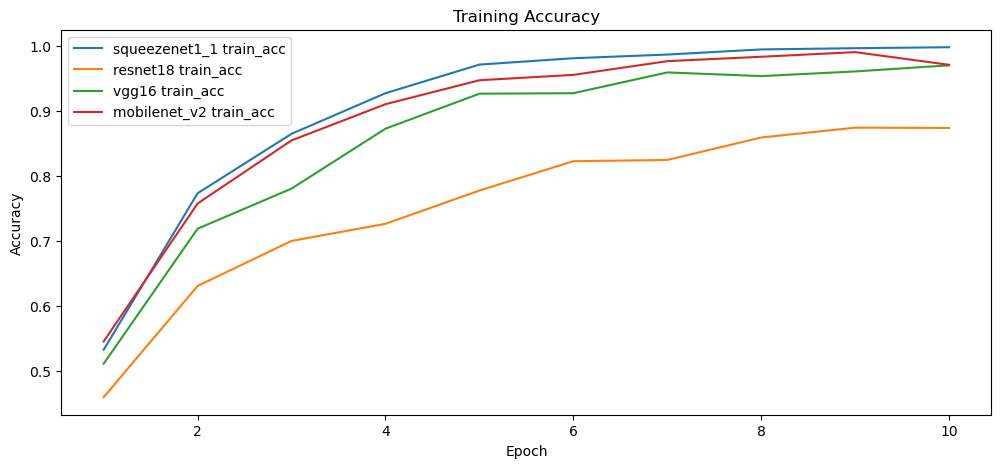

In [78]:

# ——— Line Plot for Accuracy ————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


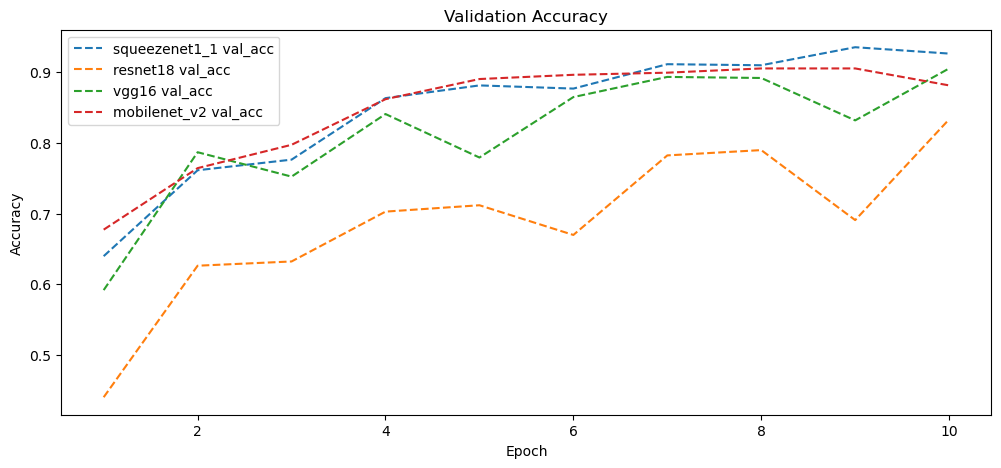

In [80]:

# ——— Line Plot for Accuracy ————————————————————————
plt.figure(figsize=(12, 5))
for name, h in histories.items():
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

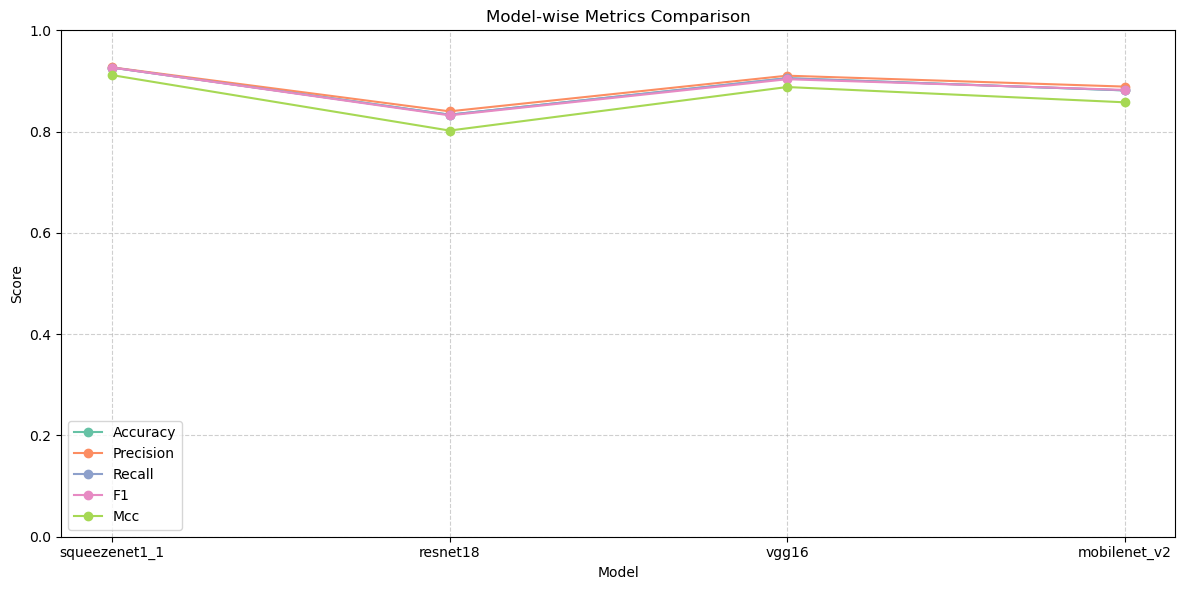

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
model_names = list(final_metrics.keys())

# Use Seaborn color palette
colors = sns.color_palette("Set2", len(metrics_list))

plt.figure(figsize=(12, 6))

# Plot each metric as a line across models
for i, metric in enumerate(metrics_list):
    values = [final_metrics[model][metric] for model in model_names]
    plt.plot(model_names, values, label=metric.capitalize(), color=colors[i], marker='o')

# Formatting the plot
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.title("Model-wise Metrics Comparison")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


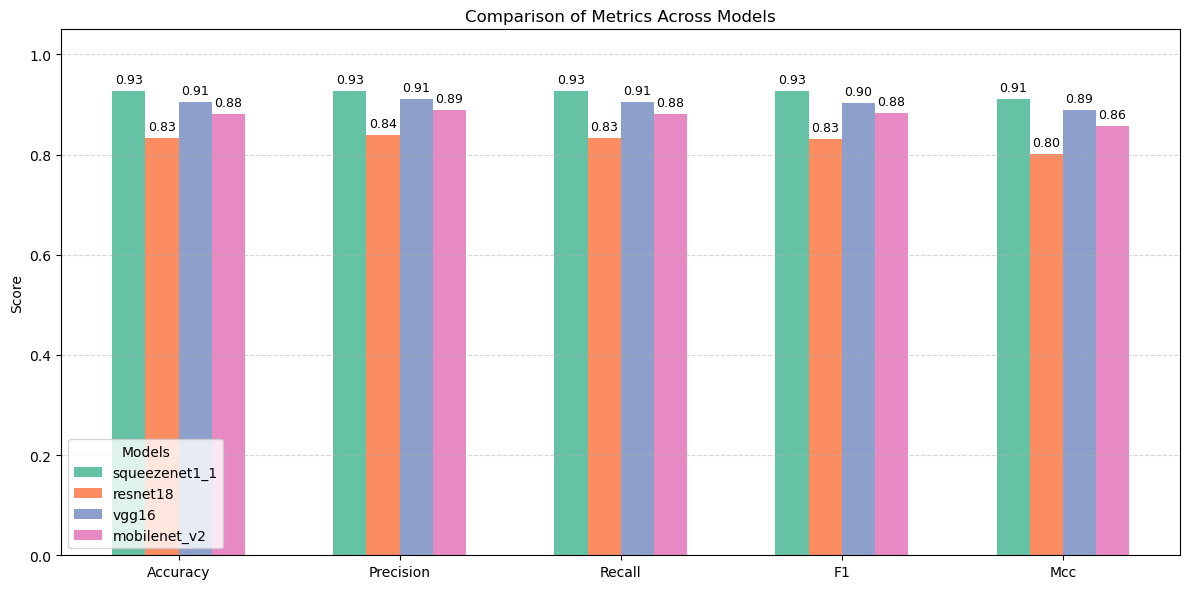

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Metrics and model names
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
model_names = list(final_metrics.keys())
n_models = len(model_names)
n_metrics = len(metrics_list)

# Prepare bar positions
bar_width = 0.15
x = np.arange(n_metrics)  # One group per metric
colors = sns.color_palette("Set2", n_models)

plt.figure(figsize=(12, 6))

# Plot bars for each model
for i, model in enumerate(model_names):
    values = [final_metrics[model][metric] for metric in metrics_list]
    positions = x + i * bar_width
    plt.bar(positions, values, width=bar_width, label=model, color=colors[i])
    
    # Add value labels above bars
    for pos, val in zip(positions, values):
        plt.text(pos, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

# Formatting
plt.xticks(x + bar_width * (n_models - 1) / 2, [m.capitalize() for m in metrics_list])
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Comparison of Metrics Across Models')
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


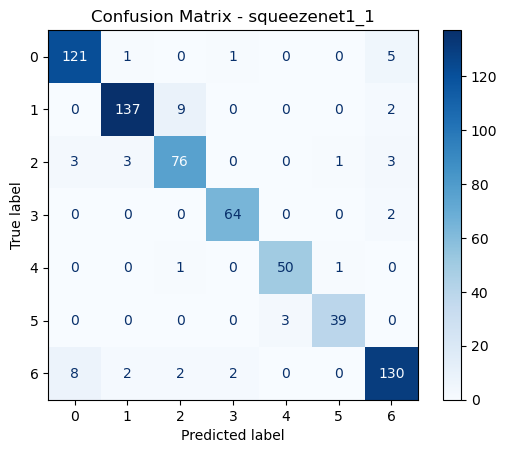

ValueError: multiclass format is not supported

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import torch.nn.functional as F

# Store for ROC curves
roc_data = {}

for name, model in models_dict.items():
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            preds = torch.argmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)


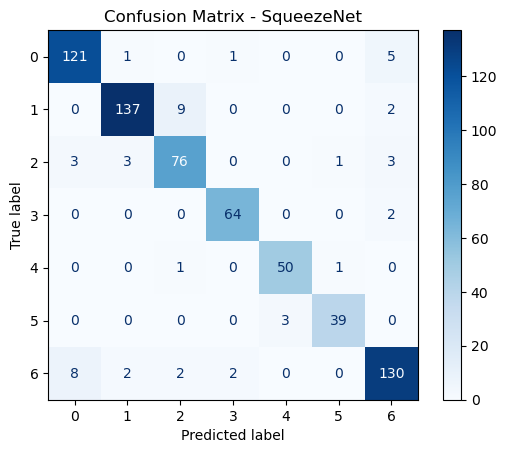

In [40]:
squeezenet_model = models_dict['squeezenet1_1']  # <-- use correct key here
squeezenet_model.eval()
squeezenet_model.to(device)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet_model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SqueezeNet')
plt.show()


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\3088255094.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


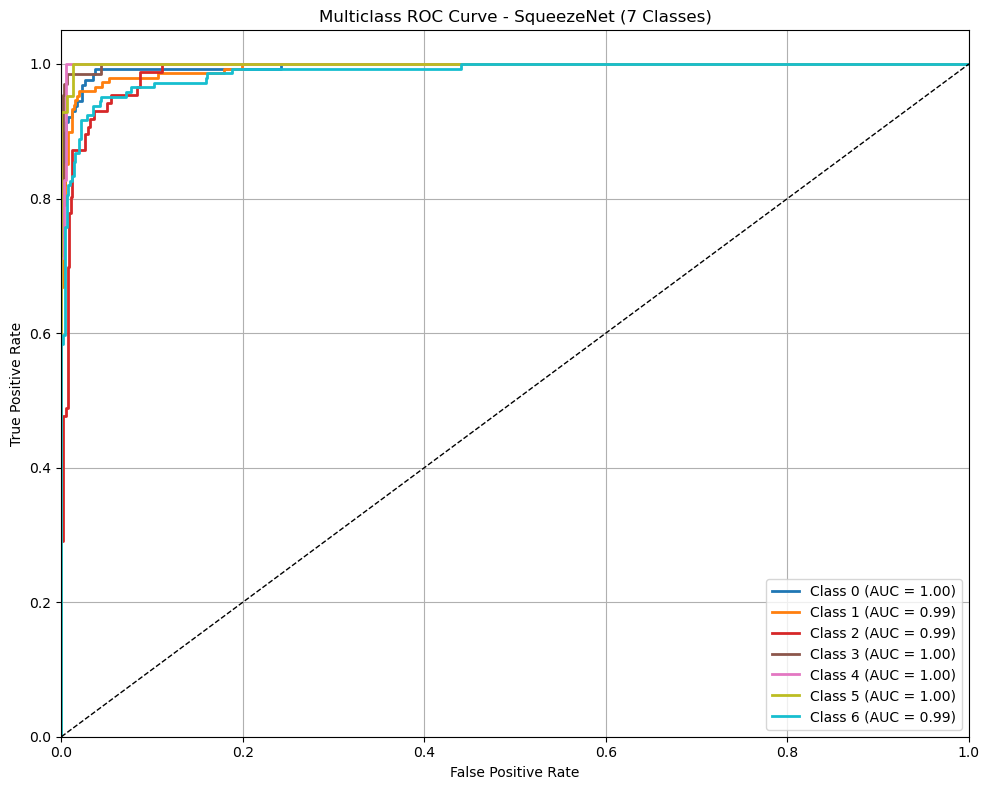

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Set up your model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeezenet_model = models_dict['squeezenet1_1']  # replace with actual key
squeezenet_model.eval()
squeezenet_model.to(device)

# Collect true labels and predicted probabilities
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack results
all_probs = np.vstack(all_probs)
all_labels = np.hstack(all_labels)

# Binarize labels for 7-class classification
n_classes = 7
binary_labels = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - SqueezeNet (7 Classes)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Other Model Results

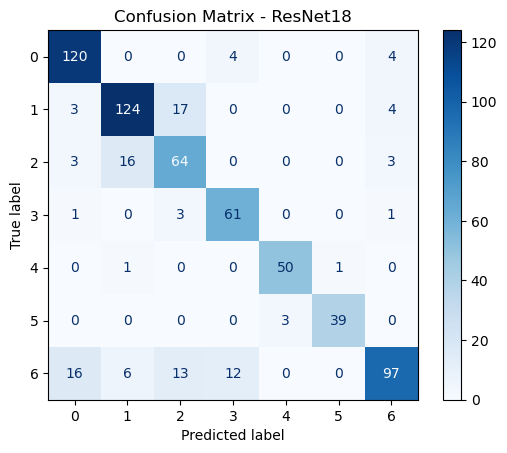

In [48]:
squeezenet_model = models_dict['resnet18']  # <-- use correct key here
squeezenet_model.eval()
squeezenet_model.to(device)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet_model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - ResNet18')
plt.show()


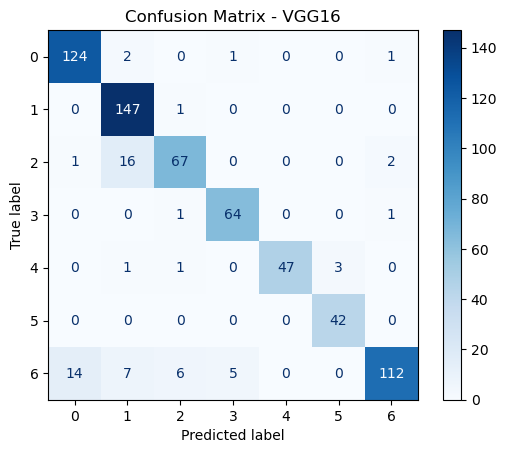

In [49]:
squeezenet_model = models_dict['vgg16']  # <-- use correct key here
squeezenet_model.eval()
squeezenet_model.to(device)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet_model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - VGG16')
plt.show()


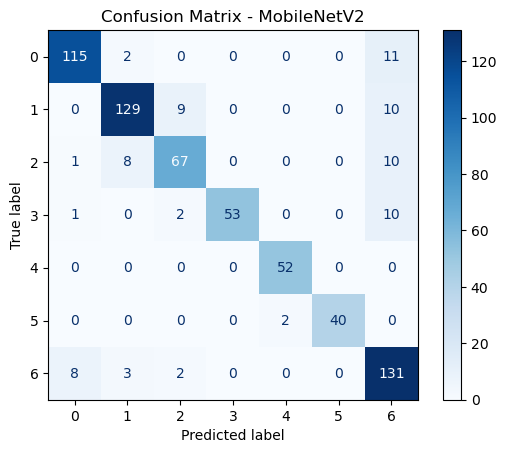

In [50]:
squeezenet_model = models_dict['mobilenet_v2']  # <-- use correct key here
squeezenet_model.eval()
squeezenet_model.to(device)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet_model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()


C:\Users\CVR\AppData\Local\Temp\ipykernel_11052\3679604505.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


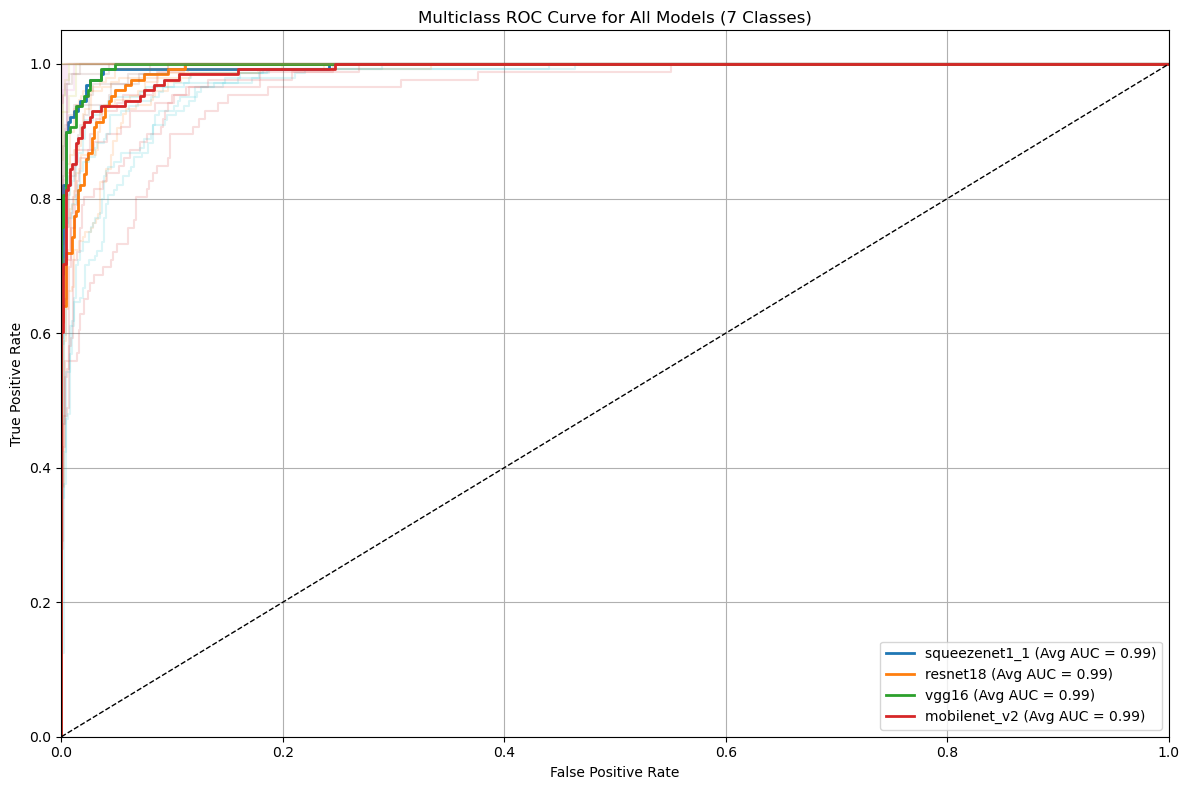

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of classes
n_classes = 7
class_range = list(range(n_classes))

# Prepare ROC curve colors
colors = plt.cm.get_cmap('tab10', n_classes)

# Plot setup
plt.figure(figsize=(12, 8))

# Loop through each model
for model_name, model in models_dict.items():
    model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Stack results
    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)

    # Binarize labels for ROC computation
    binary_labels = label_binarize(all_labels, classes=class_range)

    # Compute macro-average ROC AUC (optional)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute average AUC
    avg_auc = np.mean(list(roc_auc.values()))

    # Plot ROC for this model (macro-average, you can also plot individual classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.15, color=colors(i))

    plt.plot(fpr[0], tpr[0], lw=2, label=f'{model_name} (Avg AUC = {avg_auc:.2f})')

# Final ROC formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for All Models (7 Classes)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


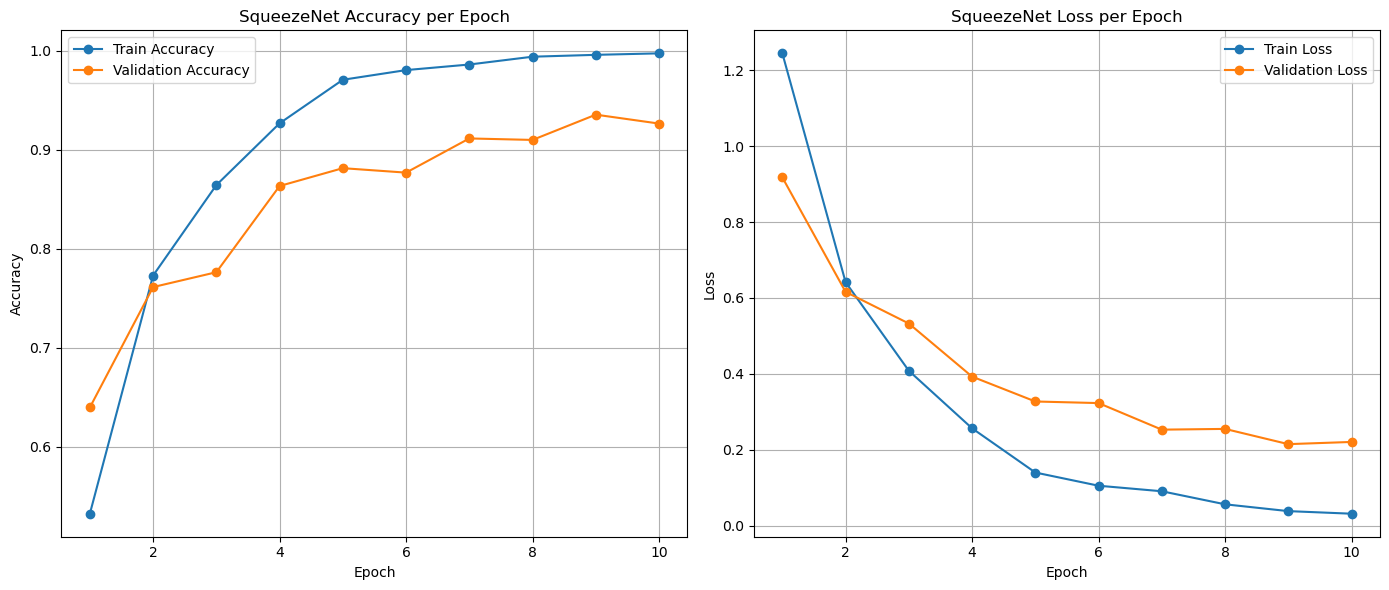

In [58]:
import matplotlib.pyplot as plt

squeezenet_history = histories['squeezenet1_1']
epochs = range(1, len(squeezenet_history['train_loss']) + 1)

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, squeezenet_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, squeezenet_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title("SqueezeNet Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, squeezenet_history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, squeezenet_history['val_loss'], label='Validation Loss', marker='o')
plt.title("SqueezeNet Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


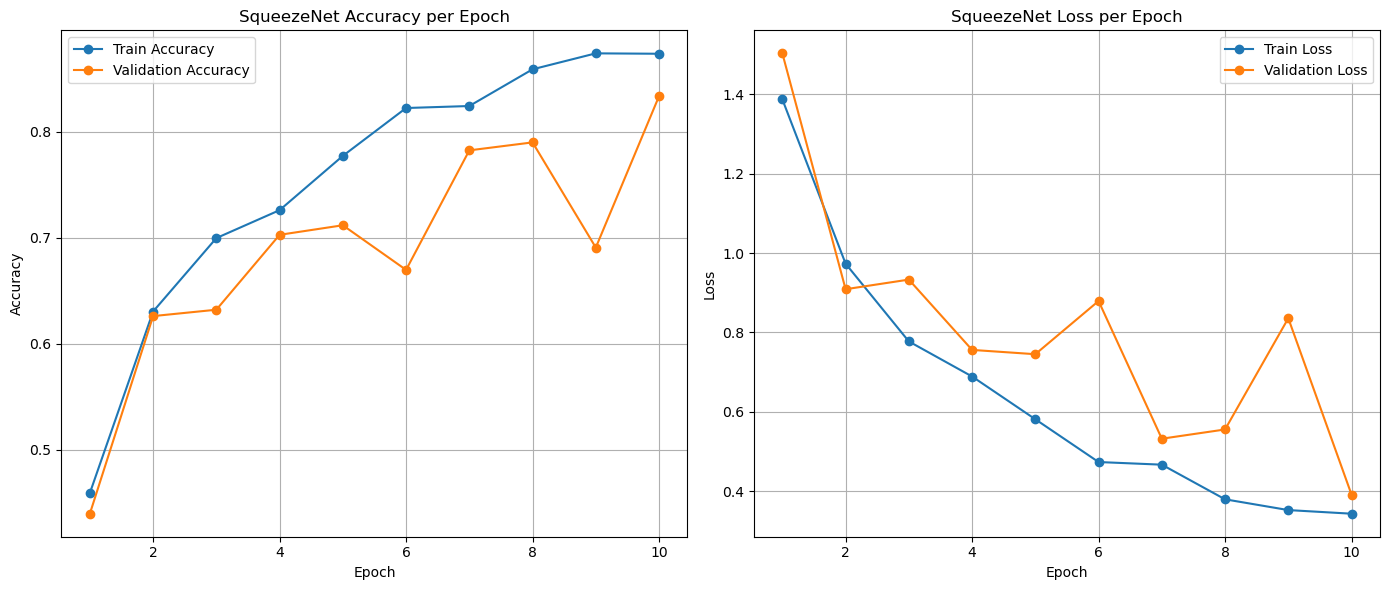

In [86]:
import matplotlib.pyplot as plt

squeezenet_history = histories['resnet18']
epochs = range(1, len(squeezenet_history['train_loss']) + 1)

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, squeezenet_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, squeezenet_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title("SqueezeNet Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, squeezenet_history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, squeezenet_history['val_loss'], label='Validation Loss', marker='o')
plt.title("SqueezeNet Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


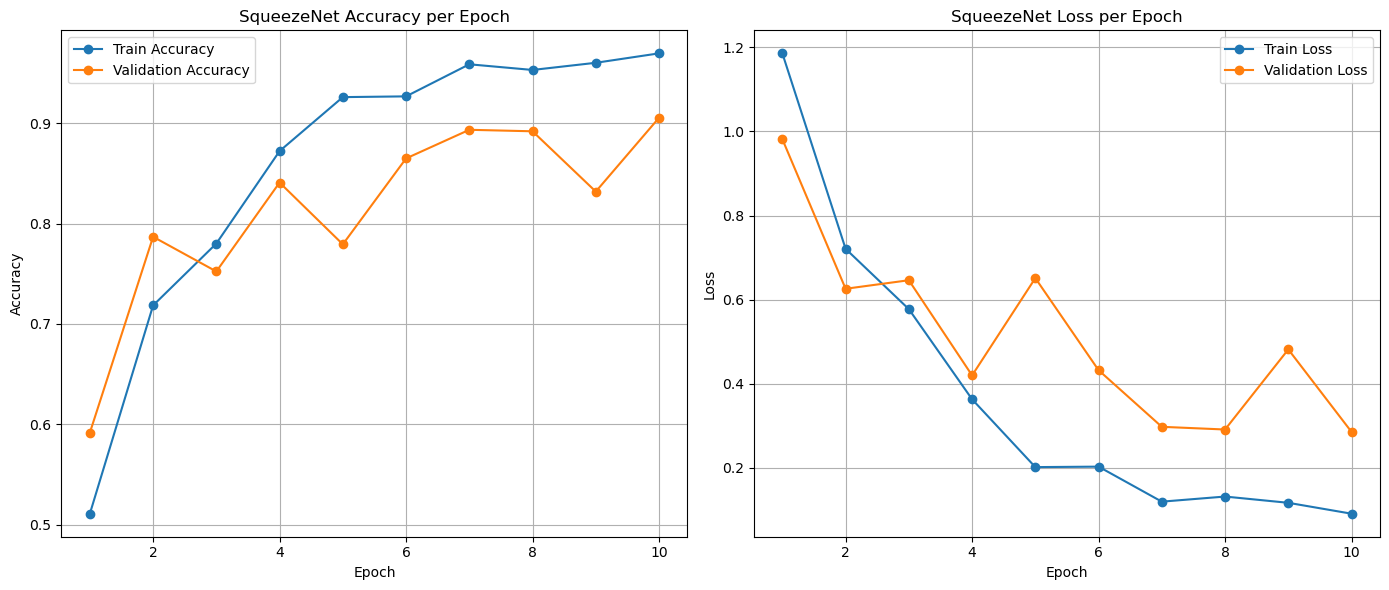

In [84]:
import matplotlib.pyplot as plt

squeezenet_history = histories['vgg16']
epochs = range(1, len(squeezenet_history['train_loss']) + 1)

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, squeezenet_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, squeezenet_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title("SqueezeNet Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, squeezenet_history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, squeezenet_history['val_loss'], label='Validation Loss', marker='o')
plt.title("SqueezeNet Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


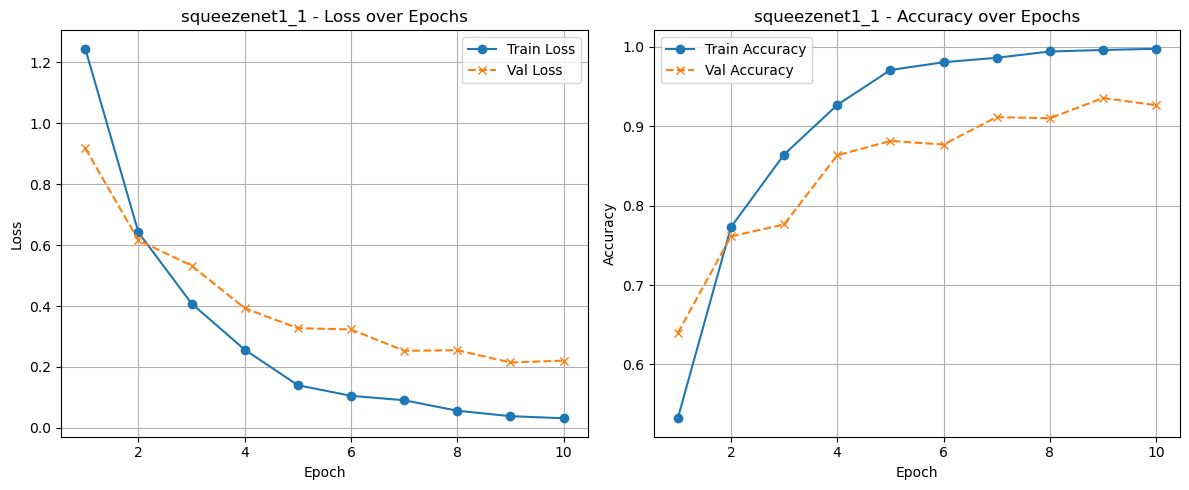

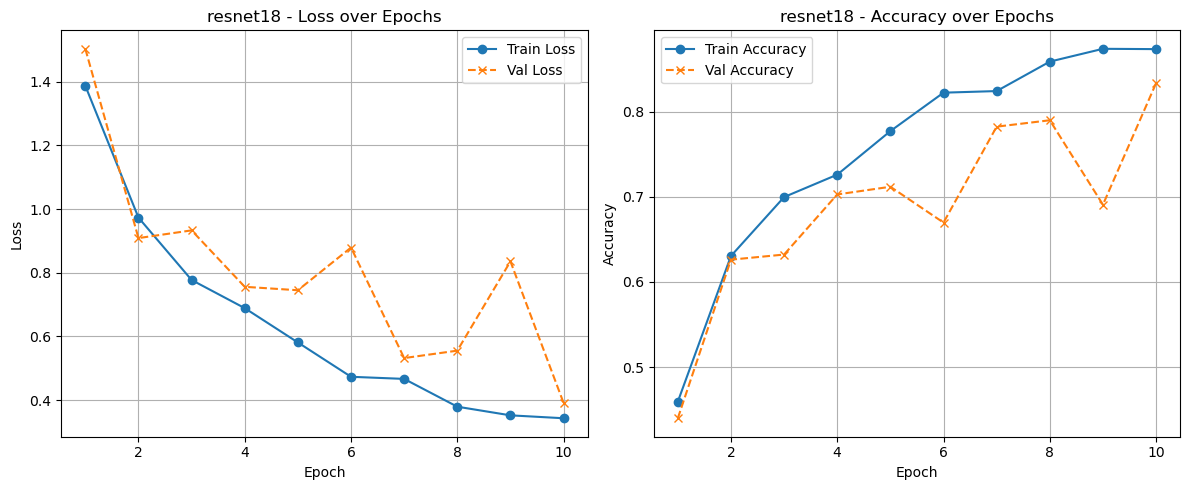

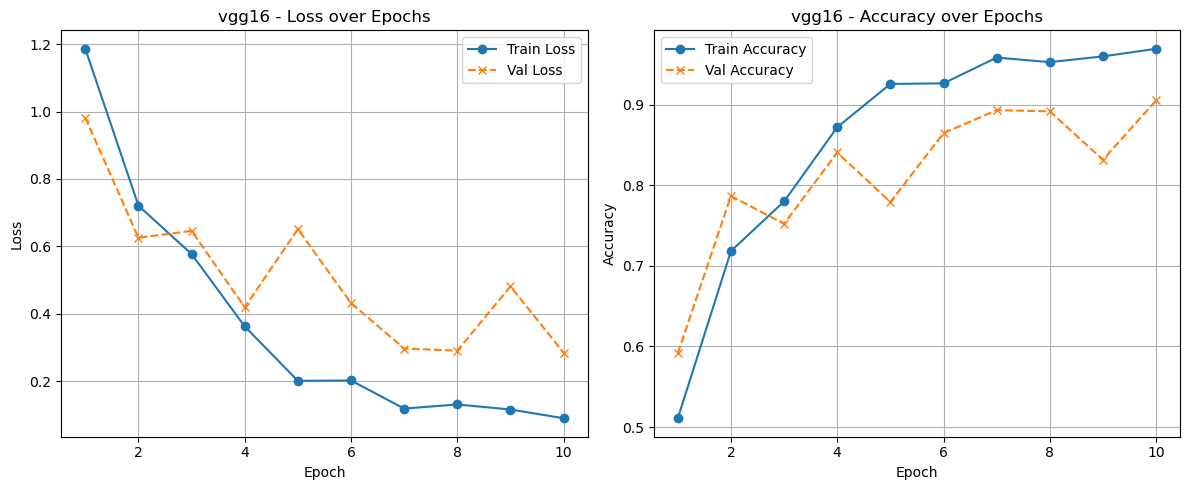

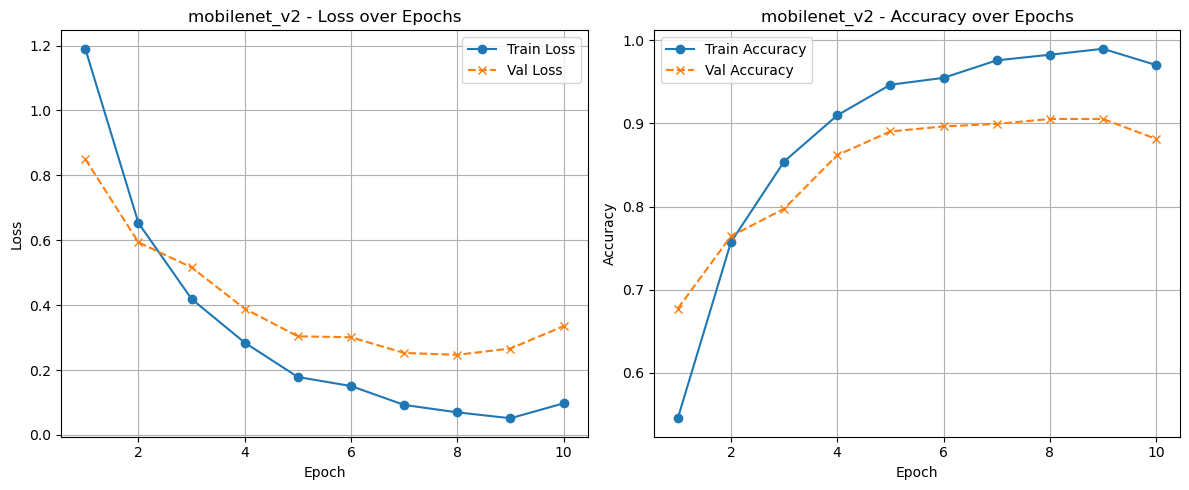

In [88]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

for name, h in histories.items():
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, h['val_loss'], label='Val Loss', linestyle='--', marker='x')
    plt.title(f'{name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, h['val_acc'], label='Val Accuracy', linestyle='--', marker='x')
    plt.title(f'{name} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
